dataset = [link text](https://www.kaggle.com/datasets/evanschreiner/netflix-movie-ratings)

In [ ]:
!pip install findspark
!pip install pyspark
import findspark
import pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('recommendation').getOrCreate()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [ ]:
data = spark.read.csv('/content/ratings.csv',inferSchema=True,header=True)

In [ ]:
data.head()

Row(userId=1, movieId=1, rating=4.0, timestamp=964982703)

In [ ]:
data.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [ ]:
data.describe().show()

+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+



In [ ]:
# Smaller dataset so we will use 0.8 / 0.2
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(train_data)

In [ ]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test_data)

In [ ]:
predictions.show()

+------+-------+------+---------+----------+
|userId|movieId|rating|timestamp|prediction|
+------+-------+------+---------+----------+
|     1|    101|   5.0|964980868| 4.4597964|
|     1|   1031|   5.0|964982653| 3.3202777|
|     1|    596|   5.0|964982838| 3.6768434|
|     1|   1197|   5.0|964981872| 4.7004185|
|     1|      6|   4.0|964982224|  4.790987|
|     1|   1089|   5.0|964982951| 5.0987177|
|     1|    923|   5.0|964981529|   4.39448|
|     1|   1220|   5.0|964981909| 4.7497883|
|     1|    231|   5.0|964981179| 2.9732854|
|     1|   1967|   4.0|964981710| 4.4756904|
|     1|    423|   3.0|964982363| 2.7019982|
|     1|    543|   4.0|964981179| 3.3585258|
|     1|    151|   5.0|964984041| 5.1790357|
|     1|    943|   4.0|964983614|  4.863847|
|     1|    940|   5.0|964982176|  4.002418|
|     1|   1573|   5.0|964982290| 3.3755217|
|     1|   1024|   5.0|964982876| 3.8420231|
|     1|    349|   4.0|964982563| 4.1473207|
|     1|   2000|   4.0|964982211| 4.6527977|
|     1|  

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = nan


In [ ]:
single_user = test_data.filter(test_data['userId']==1).select(['movieId','userId'])

In [ ]:
# User had 10 ratings in the test data set
# Realistically this should be some sort of hold out set!
single_user.show()

+-------+------+
|movieId|userId|
+-------+------+
|      6|     1|
|    101|     1|
|    151|     1|
|    231|     1|
|    349|     1|
|    423|     1|
|    543|     1|
|    596|     1|
|    923|     1|
|    940|     1|
|    943|     1|
|   1009|     1|
|   1024|     1|
|   1031|     1|
|   1089|     1|
|   1197|     1|
|   1220|     1|
|   1573|     1|
|   1805|     1|
|   1967|     1|
+-------+------+
only showing top 20 rows



In [ ]:
reccomendations = model.transform(single_user)

In [ ]:
reccomendations.orderBy('prediction',ascending=False).show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   3703|     1| 5.2263975|
|    151|     1| 5.1790357|
|   1089|     1| 5.0987177|
|    943|     1|  4.863847|
|   3578|     1| 4.8356047|
|      6|     1|  4.790987|
|   1220|     1| 4.7497883|
|   1197|     1| 4.7004185|
|   2947|     1| 4.6916275|
|   2000|     1| 4.6527977|
|   2628|     1| 4.5672197|
|   3168|     1|   4.49762|
|   2596|     1|  4.482588|
|   1967|     1| 4.4756904|
|    101|     1| 4.4597964|
|   2529|     1| 4.4579916|
|   2093|     1| 4.4540844|
|    923|     1|   4.39448|
|   2478|     1|  4.387282|
|   2005|     1|  4.334988|
+-------+------+----------+
only showing top 20 rows



In [ ]:
movie_data = spark.read.csv('/content/movies.csv',inferSchema=True,header=True)

In [ ]:
movie_data.head()

Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy')

In [ ]:
movie_data.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
movie_data.describe().show()

+-------+------------------+--------------------+------------------+
|summary|           movieId|               title|            genres|
+-------+------------------+--------------------+------------------+
|  count|              9742|                9742|              9742|
|   mean|42200.353623485935|                null|              null|
| stddev| 52160.49485443825|                null|              null|
|    min|                 1|"11'09""01 - Sept...|(no genres listed)|
|    max|            193609|À nous la liberté...|           Western|
+-------+------------------+--------------------+------------------+



In [ ]:
# Get the movie recommendations
reccomendations = model.transform(single_user)

# Join the recommendations dataset with the movies dataset on the `movieId` column
joined_df = reccomendations.join(movie_data, on='movieId', how='inner')

# Select the movie name column from the joined dataset and print it to the console
movie_names = joined_df.select('title').orderBy('prediction', ascending=False)
movie_names.show()


+--------------------+
|               title|
+--------------------+
|Fast Food, Fast W...|
|Adventures Of She...|
|Tremors 4: The Le...|
|Man of the Year (...|
|Helen of Troy (2003)|
| High Society (1956)|
|Howling II: Your ...|
|Flesh and Bone (1...|
|King of Comedy (H...|
|Awfully Big Adven...|
|     Sky High (2003)|
|Othello (Tragedy ...|
|Dead or Alive 2: ...|
|   Chase, The (1994)|
|Girl Walks Into a...|
|The Dark Tower (2...|
|Ice Cream Man (1995)|
|Woman in Love (Ru...|
|Nina's Heavenly D...|
|     Lamerica (1994)|
+--------------------+
only showing top 20 rows



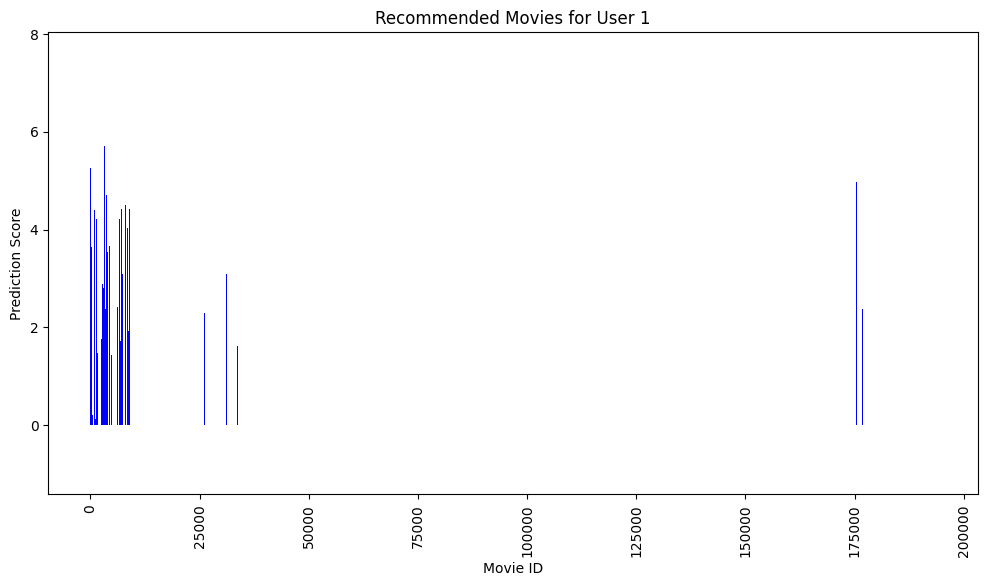

In [ ]:
from pyspark.sql.functions import lit

# Filter for a user who hasn't rated all movies in the test dataset
user_id = 1  # Change the user ID to the desired user
movies_rated_by_user = test_data.filter(test_data['userId'] == user_id).select('movieId')
all_movies = data.select('movieId').distinct()
movies_to_recommend = all_movies.subtract(movies_rated_by_user)
single_user = movies_to_recommend.withColumn('userId', lit(user_id))

# Get recommendations for the selected user
recommendations = model.transform(single_user)

# Visualize the recommendations
recommended_movies = recommendations.select(['movieId', 'prediction']).toPandas()
recommended_movies = recommended_movies.sort_values(by='prediction', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(recommended_movies['movieId'], recommended_movies['prediction'], color='blue')
plt.xlabel('Movie ID')
plt.ylabel('Prediction Score')
plt.title(f'Recommended Movies for User {user_id}')
plt.xticks(rotation=90)
plt.show()


In [ ]:
tag_data = spark.read.csv('/content/tags.csv',inferSchema=True,header=True)

In [ ]:
tag_data.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|